In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from ipynb.fs.full.utility_functions import gen_data_dict, get_data, get_cumsum, error_count, write_to_csv, opart

In [2]:
seqs   = gen_data_dict('sequence_label_data/signals.gz')
labels = gen_data_dict('sequence_label_data/labels.gz')

In [3]:
target_df_fold1 = pd.read_csv('learning_data/target_lambda_fold1.csv')
target_df_fold2 = pd.read_csv('learning_data/target_lambda_fold2.csv')

In [4]:
x1_low_fold1  = target_df_fold1['small_end'].to_numpy().reshape(-1,1)
x1_high_fold1 = target_df_fold1['big_end'].to_numpy().reshape(-1,1)
x1_low_fold2  = target_df_fold2['small_end'].to_numpy().reshape(-1,1)
x1_high_fold2 = target_df_fold2['big_end'].to_numpy().reshape(-1,1)

x2 = np.zeros(len(seqs))
for i in range(len(x2)):
    x2[i] = np.log10(np.log10(len(seqs[i][1])))
x2 = x2.reshape(-1,1)

X_label1 = np.concatenate([x2, x1_low_fold1], axis=1)
X_label1 = X_label1[X_label1[:,1] > -5]
y_label1 = np.zeros(len(X_label1))

X_label2 = np.concatenate([x2, x1_high_fold1], axis=1)
X_label2 = X_label2[X_label2[:,1] < 5]
y_label2 = np.ones(len(X_label2))

X_fold1 = np.concatenate([X_label1, X_label2])
y_fold1 = np.concatenate([y_label1, y_label2])


X_label1 = np.concatenate([x2, x1_low_fold2], axis=1)
X_label1 = X_label1[X_label1[:,1] > -5]
y_label1 = np.zeros(len(X_label1))

X_label2 = np.concatenate([x2, x1_high_fold2], axis=1)
X_label2 = X_label2[X_label2[:,1] < 5]
y_label2 = np.ones(len(X_label2))

X_fold2 = np.concatenate([X_label1, X_label2])
y_fold2 = np.concatenate([y_label1, y_label2])

In [5]:
# Create an Instance of SVM and Fit out the data. 
svc_train_fold1 = svm.SVC(kernel ='linear').fit(X_fold1, y_fold1)
svc_train_fold2 = svm.SVC(kernel ='linear').fit(X_fold2, y_fold2)

# boundary function
def linear_func(x, svc):
    w = svc.coef_[0]
    a = -w[0] / w[1]
    return a*x - (svc.intercept_[0]) / w[1]

In [6]:
svc = svc_train_fold1
print(svc.coef_[0], svc.intercept_)

svc = svc_train_fold2
print(svc.coef_[0], svc.intercept_)

[-4.30758687  1.48571781] [1.2276348]
[-3.3155771   1.59965473] [1.46673969]


Text(0, 0.5, 'log lambda')

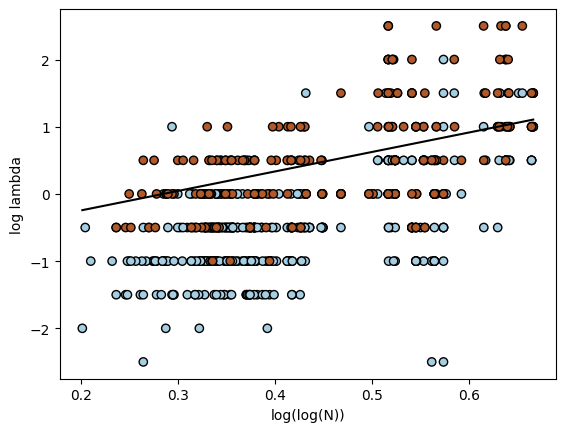

In [7]:
xx = np.linspace(X_fold1[:, 0].min(), X_fold1[:, 0].max())
yy = linear_func(xx, svc_train_fold1)

# Plot the decision boundary
plt.plot(xx, yy, 'k-')

# Plot the data points
plt.scatter(X_fold1[:, 0], X_fold1[:, 1], c=y_fold1, cmap=plt.cm.Paired, edgecolors='k', marker='o', label='Data Points')
plt.xlabel('log(log(N))')
plt.ylabel('log lambda')

Text(0, 0.5, 'log lambda')

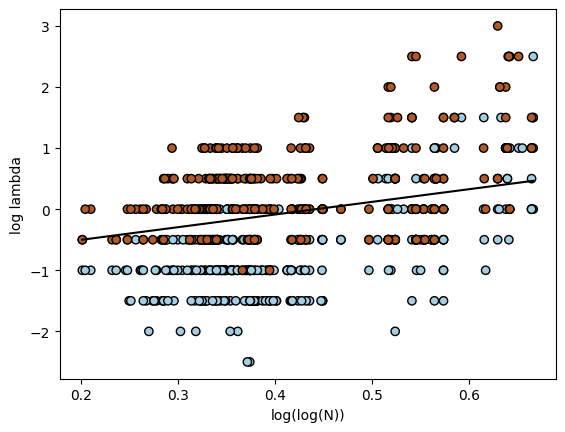

In [8]:
xx = np.linspace(X_fold2[:, 0].min(), X_fold2[:, 0].max())
yy = linear_func(xx, svc_train_fold2)

# Plot the decision boundary
plt.plot(xx, yy, 'k-')

# Plot the data points
plt.scatter(X_fold2[:, 0], X_fold2[:, 1], c=y_fold2, cmap=plt.cm.Paired, edgecolors='k', marker='o', label='Data Points')
plt.xlabel('log(log(N))')
plt.ylabel('log lambda')

In [9]:
header = ['sequenceID', 'fold_1_total_labels', 'fold_2_total_labels', 'fold_1_errs', 'fold_2_errs']

for i in range(len(seqs)):
    # generate data
    sequence, neg_start_1, neg_end_1, pos_start_1, pos_end_1, neg_start_2, neg_end_2, pos_start_2, pos_end_2 = get_data(i, seqs=seqs, labels=labels)
    sequence_length = len(sequence)-1

    # vectors of cumulative sums
    y, z = get_cumsum(sequence)

    # calculate lambda
    lda_test_fold2 = linear_func(np.log10(np.log10(sequence_length)), svc_train_fold1)
    lda_test_fold1 = linear_func(np.log10(np.log10(sequence_length)), svc_train_fold2)

    # get total labels
    fold1_total_labels = len(neg_start_1) + len(pos_start_1)
    fold2_total_labels = len(neg_start_2) + len(pos_start_2)

    # run each lambda and record it into csv file
    row  = [i, fold1_total_labels, fold2_total_labels]

    chpnt_fold1 = opart(10**lda_test_fold1, sequence, y, z)
    chpnt_fold2 = opart(10**lda_test_fold2, sequence, y, z)

    err_1 = error_count(chpnt_fold1, neg_start_1, neg_end_1, pos_start_1, pos_end_1)
    err_2 = error_count(chpnt_fold2, neg_start_2, neg_end_2, pos_start_2, pos_end_2)
    
    row.append(sum(err_1))
    row.append(sum(err_2))

    write_to_csv('learning_output/linear_SVM.csv', header, row)